In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import tensorflow as tf
import keras
import os
from PIL import Image
from matplotlib import pyplot as plt
from moviepy.editor import *
import cv2
import moviepy
import sys
import random
import tensorflow.keras.layers as tfKL
import sklearn
from tensorflow.keras import regularizers
from keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
import random
import pandas as pd
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Concatenate, Input, Lambda,LSTM,Reshape
from tensorflow.keras.models import Model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2015232/45929032 bytes (4.4%)5816320/45929032 bytes (12.7%)9666560/45929032 bytes (21.0%)13451264/45929032 bytes (29.3%)17260544/45929032 bytes (37.6%)21176320/45929032 bytes (46.1%)25010176/45929032 bytes (54.5%)28835840/45929032 bytes (62.8%)32768000/45929032 bytes (71.3%)36749312/45929032 bytes (80.0%)40452096/45929032 bytes (88.1%)44376064/45929032 bytes (96.6%)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
mainPath="/content/gdrive/MyDrive/hand sign database"

Mounted at /content/gdrive


In [ ]:
nCategories=8

In [ ]:
partition ={}
labels ={}
partition['train']=list()
partition['validation']=list()
partition['test']=list()
def mapCatToNumber(file1):
  strings=[]
  for cat in os.listdir(file1):
    strings.append(cat)
  stringsS=sorted(strings)
  answer={}
  for i in range(len(stringsS)):
    answer[stringsS[i]]=i
  return answer
mappingCatToN=mapCatToNumber(mainPath)
print(mappingCatToN)

{'accident': 0, 'call': 1, 'doctor': 2, 'help': 3, 'hot': 4, 'lose': 5, 'pain': 6, 'thief': 7}


In [ ]:
for category in os.listdir(mainPath):
  print(category)
  vidL=[]
  for video in os.listdir(os.path.join(mainPath,category)):
    vidL.append(os.path.join(mainPath,category,video))
  lenVidL=len(vidL)
  trainLen=(int)(3*lenVidL/4)
  testLen=int(lenVidL/10)
  valLen=lenVidL-trainLen-testLen
  print(trainLen," ",valLen," ",testLen)
  random.shuffle(vidL)
  for i in range(lenVidL):
    labels[vidL[i]]=mappingCatToN[category]
    if i<trainLen:
      partition['train'].append(vidL[i])
    elif i<trainLen+valLen:
      partition['validation'].append(vidL[i])
    else:
      partition['test'].append(vidL[i])

help
39   8   5
thief
37   8   5
call
39   8   5
hot
39   8   5
pain
39   8   5
accident
39   8   5
lose
30   6   4
doctor
39   8   5


In [ ]:
print(np.shape(partition['train']))
print(np.shape(partition['validation']))
print(np.shape(partition['test']))

(301,)
(62,)
(39,)


In [ ]:
import pickle
with tf.device("/device:GPU:0"):
  with open('/content/gdrive/MyDrive/VGG16 models and history/PARTITION', 'wb') as file_pi:
    pickle.dump(partition, file_pi)

In [ ]:
import numpy as np
from tensorflow import keras
class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, labels, batch_size=32, dim=(20,224,224,3), n_classes=8, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      # Store sample
      # X[i,] = np.load('data/' + ID + '.npy')
      ######
      # print(ID)
      try:
        vidObj = moviepy.editor.VideoFileClip(ID)
      except IOError as e:
        errno, strerror = e.args
        print(errno)
        print(strerror)
      video_duration = int(vidObj.duration)   
      nFrames=self.dim[0]
      array=np.empty(shape=(nFrames,224,224,3))
      frameSize=(self.dim[1],self.dim[2])
      for k in range(nFrames):
        frame=vidObj.get_frame((k+1)*video_duration/(nFrames*1.0))
        frameR=Image.fromarray(frame).convert("RGB")
        frame2=frameR.resize(frameSize)
        arrayi=np.array(frame2)/255
        # if k is 0:
        #   print(np.shape(arrayi))
        array[k]=arrayi
        del arrayi
      # print(np.shape(array))
      X[i,]=array
      del array
      #######
      # Store class
      y[i] = self.labels[ID]
    print("Shape of X output by data generator: ",np.shape(X))
    return np.array(X), keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
def createModel4(Tframes=20,batch_size=10,epochs=500,verbose=2,metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam',nLstmUnits=147):
  input=Input(shape=(Tframes,224,224,3))
  branchOutputs=[]
  vgg=VGG16(include_top=False,input_shape=(224,224,3))
  for i in range(Tframes):
    out=Lambda(lambda x: x[:,i,:,:,:])(input)
    print("out.shape: ",out.shape)
    name="vgg16_"+str(i)
    tempModel=Sequential(name=name)
    # tempModel.add(VGG16(include_top=False,input_shape=(224,224,3)))
    tempModel.add(vgg)
    out1=tempModel(out)
    branchOutputs.append(out1)
  out = Concatenate()(branchOutputs)
  '''
  model=Model(inputs=input,outputs=out)
  model2=Sequential()
  model2.add(model)
  model2.add(tfKL.TimeDistributed(LSTM(units=nLstmUnits,activation='tanh',input_shape=(None,7,7,512))))
  model2.add(tfKL.Flatten())
  model2.add(Dense(units=8,activation='softmax'))
  model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  '''
  out=tfKL.TimeDistributed(LSTM(units=nLstmUnits,activation='tanh',input_shape=(None,7,7,512)))(out)
  out=tfKL.Flatten()(out)
  out=Dense(units=8,activation='softmax')(out)
  model=Model(inputs=input,outputs=out)
  model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
  for layer in model.layers:
    print(layer.name)
  return model

In [ ]:
def getLabels(partition=partition):
  labels={}
  mainPath="/content/gdrive/MyDrive/hand sign database"
  for category in os.listdir(mainPath):
    print(category)
    vidL=[]
    for video in os.listdir(os.path.join(mainPath,category)):
      vidL.append(os.path.join(mainPath,category,video))
      lenVidL=len(vidL)
      random.shuffle(vidL)
      for i in range(lenVidL):
        labels[vidL[i]]=mappingCatToN[category]
  return  labels
labels=getLabels()
print(labels)

help
thief
call
hot
pain
accident
lose
doctor
{'/content/gdrive/MyDrive/hand sign database/help/help_Crop_001_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_001_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_005_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_004_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_007_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_002_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_006_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_003_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_010_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_010_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_007_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_008_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help

In [ ]:
import gc
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
  def on_batch_end(self, epoch, logs=None):
    print("Batch end")
    gc.enable()
    gc.collect()
    gc.collect()
    return

58892288/58889256 [==============================] - 1s 0us/step
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
input_1
lambda
lambda_1
lambda_2
lambda_3
lambda_4
lambda_5
lambda_6
lambda_7
lambda_8
lambda_9
lambda_10
lambda_11
lambda_12
lambda_13
lambda_14
lambda_15
lambda_16
lambda_17
vgg16_0
vgg16_1
vgg16_2
vgg16_3
vgg16_4
vgg16_5
vgg16_6
vgg16_7
vgg16_8
vgg16_9
vgg16_10
vgg16_11
vgg16_12
vgg16_13
vgg16_14
vgg16_15
vgg16_16
vgg16_17
concatenate
time_distributed
fl

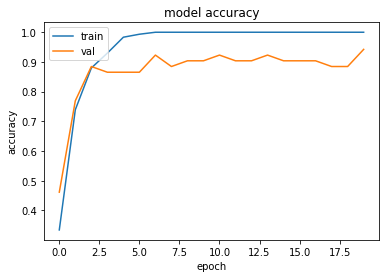

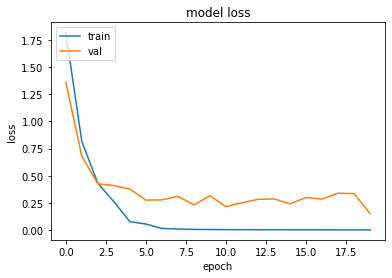

Time taken:  2847.175096511841


In [ ]:
with tf.device('/device:GPU:0'):
  Tframes=18
  batch_size=13
  nLstmUnits=180#220 #200
  params = {'dim': (Tframes,224,224,3),
            'batch_size': batch_size,
            'n_classes': 8,
            'shuffle': True}
  epochs=20
  # Generators
  training_generator = DataGenerator(partition['train'], labels, **params)
  validation_generator = DataGenerator(partition['validation'], labels, **params)


  model=createModel4(Tframes=Tframes,nLstmUnits=nLstmUnits,optimizer=keras.optimizers.SGD(lr=0.01, nesterov=True))
  begin=time.time()
  history=model.fit_generator(epochs=epochs,verbose=2,generator=training_generator,
                    validation_data=validation_generator,callbacks=[LossAndErrorPrintingCallback()])
  end=time.time()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print("Time taken: ",end-begin)

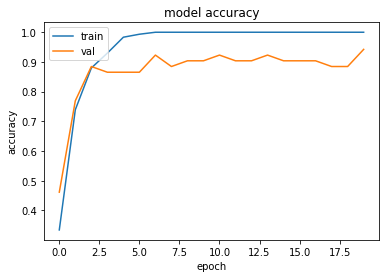

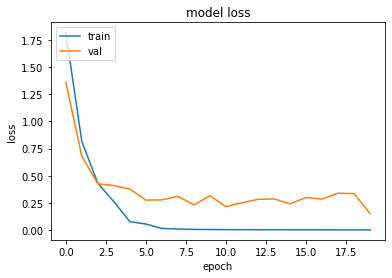

{'loss': [1.8189260959625244, 0.8146510720252991, 0.43182215094566345, 0.26145660877227783, 0.07774984836578369, 0.056277647614479065, 0.01631818152964115, 0.010017669759690762, 0.007184142712503672, 0.00585594680160284, 0.004888932220637798, 0.004334527067840099, 0.0038255711551755667, 0.003430579788982868, 0.003169167786836624, 0.002932049334049225, 0.0026512013282626867, 0.0025351266376674175, 0.002384596737101674, 0.0022152725141495466], 'val_loss': [1.3596045970916748, 0.6788988709449768, 0.42663171887397766, 0.40885859727859497, 0.37808340787887573, 0.276499480009079, 0.27838990092277527, 0.31074097752571106, 0.23261763155460358, 0.31621965765953064, 0.21595653891563416, 0.25183799862861633, 0.2833367586135864, 0.2874838709831238, 0.2419569194316864, 0.30100879073143005, 0.2856528162956238, 0.339800626039505, 0.3354806900024414, 0.15133541822433472], 'accuracy': [0.3344481587409973, 0.739130437374115, 0.8795986771583557, 0.9297658801078796, 0.9832776188850403, 0.9933110475540161,

In [ ]:
HIST={}
HIST['loss']=list()
HIST['val_loss']=list()
HIST['accuracy']=list()
HIST['val_accuracy']=list()
# with tf.device("/device:GPU:0"):
#   with open('/content/gdrive/MyDrive/vgg16 models and history/HISTORY', 'rb') as file_pi:
#     prevh=pickle.load(file_pi)

# for loss in prevh['loss']:
#   HIST['loss'].append(loss)

# for loss in prevh['val_loss']:
#   HIST['val_loss'].append(loss)

# for acc in prevh['accuracy']:
#   HIST['accuracy'].append(acc)

# for acc in prevh['val_accuracy']:
#   HIST['val_accuracy'].append(acc)
#######################
#######################
for loss in history.history['loss']:
  HIST['loss'].append(loss)

for loss in history.history['val_loss']:
  HIST['val_loss'].append(loss)

for acc in history.history['accuracy']:
  HIST['accuracy'].append(acc)

for acc in history.history['val_accuracy']:
  HIST['val_accuracy'].append(acc)


plt.plot(HIST['accuracy'])
plt.plot(HIST['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(HIST['loss'])
plt.plot(HIST['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print(HIST)
# with open('/content/gdrive/MyDrive/vgg16 models and history/HISTORY', 'wb') as file_pi:
#   pickle.dump(HIST, file_pi)

In [ ]:
# with tf.device("/device:GPU:0"):
#   epochs=1
#   begin=time.time()
#   history1=model.fit_generator(epochs=epochs,verbose=2,generator=training_generator,
#                     validation_data=validation_generator,callbacks=[LossAndErrorPrintingCallback()])
#   end=time.time()

Shape of X output by data generator:  (13, 18, 224, 224, 3)
Shape of X output by data generator:  (13, 18, 224, 224, 3)
Shape of X output by data generator:  (13, 18, 224, 224, 3)


In [ ]:
# hist={}
  
# hist['accuracy']=list()
# hist['val_accuracy']=list()
# hist['loss']=list()
# hist['val_loss']=list()

# hist['accuracy']=history.history['accuracy']+history1.history['accuracy']
# hist['val_accuracy']=history.history['val_accuracy']+history1.history['val_accuracy']
# hist['loss']=history.history['loss']+history1.history['loss']
# hist['val_loss']=history.history['val_loss']+history1.history['val_loss']


# plt.plot(hist['accuracy'])
# plt.plot(hist['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# plt.plot(hist['loss'])
# plt.plot(hist['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# print("Time taken: ",end-begin)

In [ ]:
# history.history['accuracy']=hist['accuracy']
# history.history['val_accuracy']=hist['val_accuracy']
# history.history['loss']=hist['loss']
# history.history['val_loss']=hist['val_loss']

In [ ]:
with open("/content/gdrive/MyDrive/VGG16 models and history/HISTORY",'wb') as f:
  pickle.dump(HIST,f)

In [ ]:
def testAccuracy(Result,testSetY):
  diff=np.asarray(Result)-np.asarray(testSetY)
  answer=(((np.shape(diff))[0]-np.count_nonzero(diff)))/(np.shape(diff)[0])
  return answer

In [ ]:
with tf.device('/device:GPU:0'):
  params1 = params
  params1['shuffle']=False
  params1['batch_size']=1
  testing_generator = DataGenerator(partition['test'], labels, **params1)
  res=model.predict_generator(testing_generator,callbacks=LossAndErrorPrintingCallback())

In [ ]:
res2=np.argmax(res,axis=1)
print("Our prediction: ")
print(res2)
testY=[]
for el in partition['test']:
  testY.append(labels[el])
print("Truth: ")
print(testY)

In [ ]:
print(testAccuracy(res2,testY))

In [ ]:
# with tf.device('/device:GPU:0'):
#   model.save('/content/gdrive/MyDrive/VGG16 models and history/vgg16model.h5')

In [ ]:
# with tf.device('/device:GPU:0'):
#   loadedModel=keras.models.load_model('/content/gdrive/MyDrive/VGG16 models and history/vgg16model.h5')
#   loadedModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 18, 224, 224 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
gc.collect()

15047